In [1]:
import numpy as np
import seaborn as sb
from Utils.recsys2022DataReader import *
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
import matplotlib.pyplot as plt

In [2]:
URM = createURMBinary()
ICM = createSmallICM()

/Users/matteopancini/PycharmProjects/recsys-challenge-2022-Pancini-Vitali/Utils/recsys2022DataReader.py:57: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(urmPath)


In [3]:
profile_length = np.ediff1d(URM.indptr)
profile_length, profile_length.shape

(array([ 66,  21, 103, ...,  23,  53,  23], dtype=int32), (41629,))

In [4]:
sorted_users = np.argsort(profile_length)
sorted_users

array([38400, 30257, 25061, ..., 19407,  8693, 12454])

In [5]:
URM_train, URM_test = split_train_in_two_percentage_global_sample(URM, train_percentage=0.85)

In [6]:
interactions = []
for i in range(41629):
    interactions.append(len(URM[i,:].nonzero()[0]))

In [7]:
from Recommenders.Implicit.ImplicitALSRecommender import ImplicitALSRecommender
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.KNN.ItemKNNCFRecommenderPLUS import ItemKNNCFRecommender
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender

MAP_recommender_per_group = {}

collaborative_recommender_class = {
                                    "IALS": ImplicitALSRecommender,
                                    "ItemKNNCF": ItemKNNCFRecommender,
                                   "RP3beta": RP3betaRecommender,
                                   #"SlimElasticNet": MultiThreadSLIM_SLIMElasticNetRecommender,
                                   }

recommender_object_dict = {}

for label, recommender_class in collaborative_recommender_class.items():
    recommender_object = recommender_class(URM_train)

    if(label == 'ItemKNNCF'):
        recommender_object.fit(ICM=ICM, shrink=919, topK=584, similarity='dice', normalization='bm25')
    elif(label == 'IALS'):
        recommender_object.fit(factors=110, alpha=7, iterations=57, regularization=0.0008866558623568822)
    elif(label == 'RP3beta'):
        recommender_object.fit(topK=54, alpha=0.8285172350759491, beta=0.292180138700761)
    elif(label == 'SlimElasticNet'):
        recommender_object.fit(topK=359, alpha=0.04183472018614359, l1_ratio=0.03260349571135893)
    else:
        recommender_object.fit()

    recommender_object_dict[label] = recommender_object

  0%|          | 0/57 [00:00<?, ?it/s]

Done: 100%|██████████| 24507/24507 [00:08<00:00, 2799.42it/s]            


RP3betaRecommender: Similarity column 24507 (100.0%), 3981.42 column/sec. Elapsed time 6.16 sec


## OLD Interactions split

In [8]:
cutoff = 10
from Evaluation.Evaluator import EvaluatorHoldout

list_group_interactions = [[0, 20], [21, 49], [50, max(interactions)]]
for group_id in range(3):
    lower_bound = list_group_interactions[group_id][0]
    higher_bound = list_group_interactions[group_id][1]

    users_in_group = [user_id for user_id in range(len(interactions)) if (lower_bound <= interactions[user_id] <= higher_bound)]
    users_in_group_p_len = profile_length[users_in_group]
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
            group_id,
            users_in_group.shape[0],
            users_in_group_p_len.mean(),
            np.median(users_in_group_p_len),
            users_in_group_p_len.min(),
            users_in_group_p_len.max()))

    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]

    print(f"Evaluating group: {group_id}")

    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)

    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
        else:
            MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]

Evaluating group: 0
EvaluatorHoldout: Ignoring 991 ( 2.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 32533 Users
EvaluatorHoldout: Processed 8417 (100.0%) in 5.60 sec. Users per second: 1503
EvaluatorHoldout: Processed 8417 (100.0%) in 5.57 sec. Users per second: 1511
EvaluatorHoldout: Processed 8417 (100.0%) in 3.94 sec. Users per second: 2134
Evaluating group: 1
EvaluatorHoldout: Ignoring 991 ( 2.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 16708 Users
EvaluatorHoldout: Processed 24609 (100.0%) in 14.61 sec. Users per second: 1685
EvaluatorHoldout: Processed 24609 (100.0%) in 17.34 sec. Users per second: 1420
EvaluatorHoldout: Processed 24609 (100.0%) in 10.81 sec. Users per second: 2276
Evaluating group: 2
EvaluatorHoldout: Ignoring 991 ( 2.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 34017 Users
EvaluatorHoldout: Processed 7612 (100.0%) in 5.31 sec. Users per second: 1433
EvaluatorHoldout

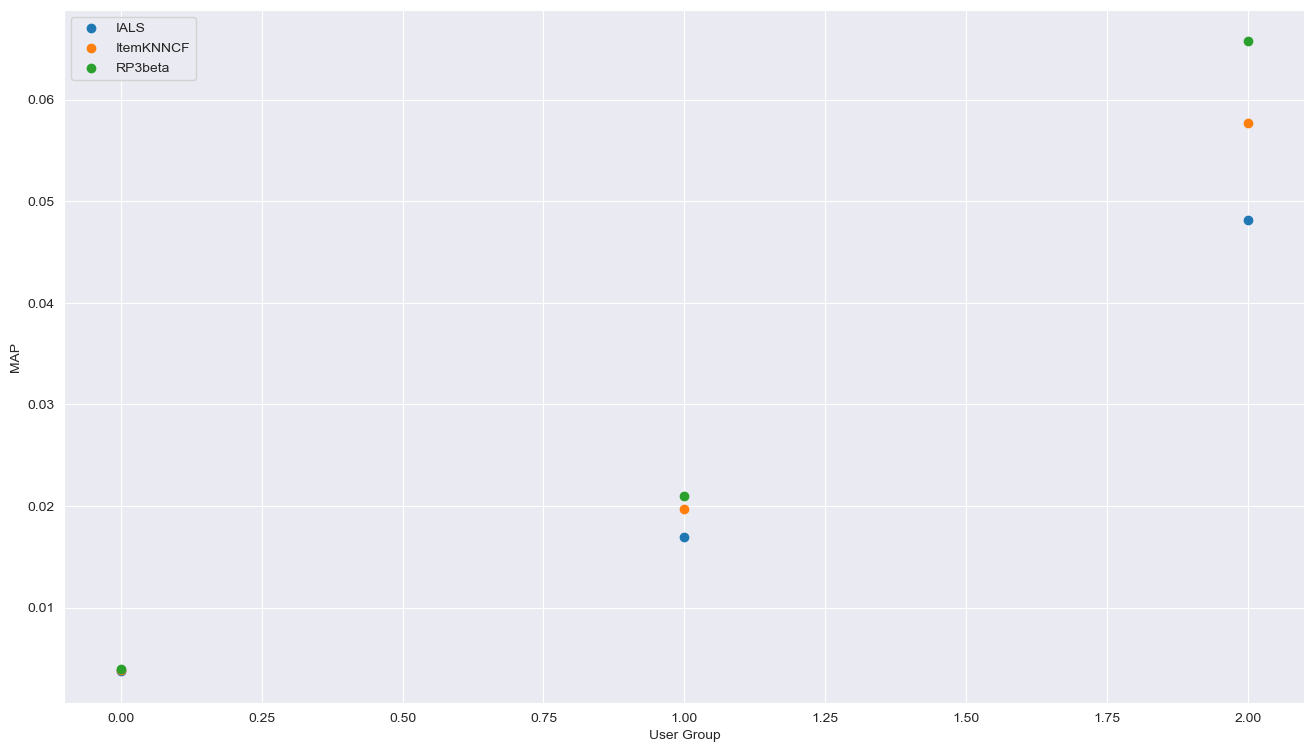

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0,len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()

### 25%

In [13]:
cutoff = 10
from Evaluation.Evaluator import EvaluatorHoldout

block_size = int(len(profile_length) * 0.25)
for group_id in range(4):
    start_pos = group_id * block_size
    end_pos = min((group_id + 1) * block_size, len(profile_length))

    users_in_group = sorted_users[start_pos:end_pos]

    users_in_group_p_len = profile_length[users_in_group]
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
            group_id,
            users_in_group.shape[0],
            users_in_group_p_len.mean(),
            np.median(users_in_group_p_len),
            users_in_group_p_len.min(),
            users_in_group_p_len.max()))

    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]

    print(f"Evaluating group: {group_id}")

    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)

    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
        else:
            MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]

Evaluating group: 0
EvaluatorHoldout: Ignoring 991 ( 2.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 31222 Users
EvaluatorHoldout: Processed 9690 (100.0%) in 6.42 sec. Users per second: 1508
EvaluatorHoldout: Processed 9690 (100.0%) in 6.50 sec. Users per second: 1490
EvaluatorHoldout: Processed 9690 (100.0%) in 4.51 sec. Users per second: 2149
Evaluating group: 1
EvaluatorHoldout: Ignoring 991 ( 2.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 31222 Users
EvaluatorHoldout: Processed 10189 (100.0%) in 6.51 sec. Users per second: 1566
EvaluatorHoldout: Processed 10189 (100.0%) in 7.27 sec. Users per second: 1401
EvaluatorHoldout: Processed 10189 (100.0%) in 4.80 sec. Users per second: 2124
Evaluating group: 2
EvaluatorHoldout: Ignoring 991 ( 2.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 31222 Users
EvaluatorHoldout: Processed 10354 (100.0%) in 6.66 sec. Users per second: 1556
EvaluatorHoldout: 

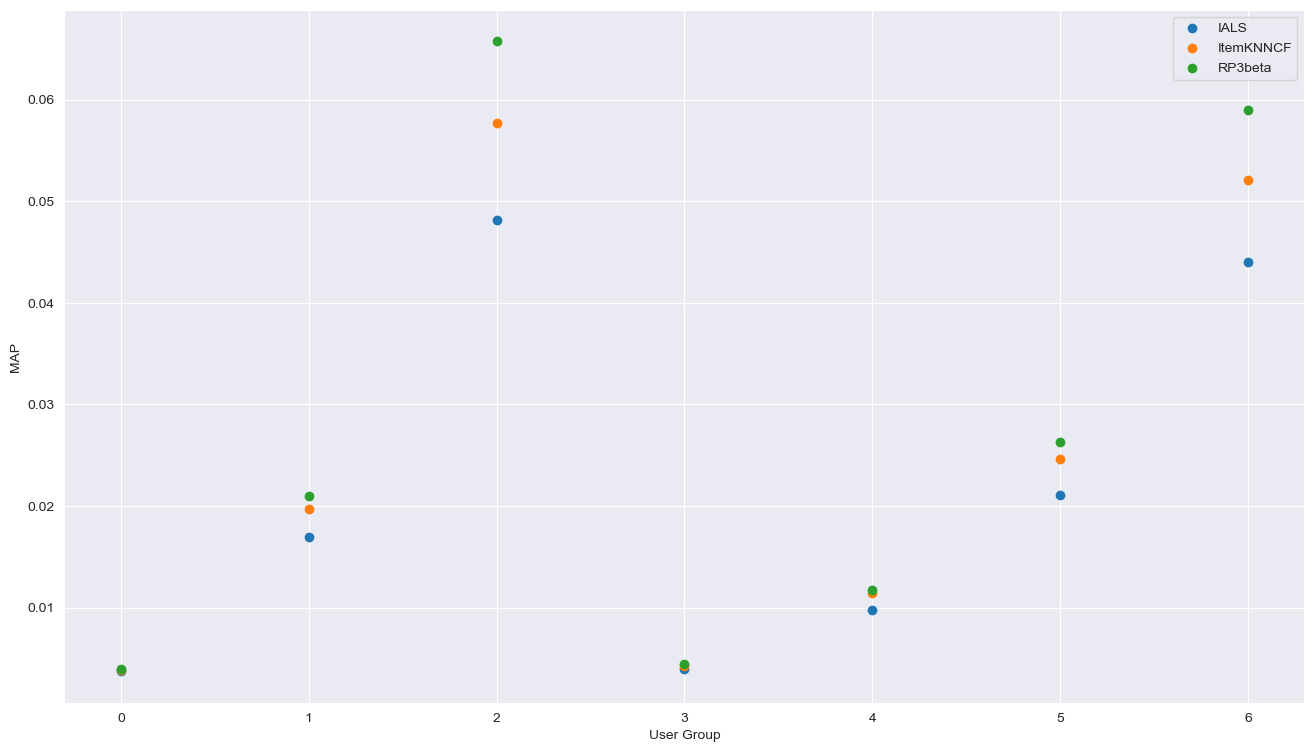

In [15]:
import matplotlib.pyplot as plt

_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0, len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()